In [ ]:
import scripts.filtering as filtering
def create_corpus_files(list, train=False):
    lang1_list = list[0].split("\n")
    lang2_list = list[1].split("\n")
    lang1_ids = []
    lang2_ids = []
    for item in lang1_list:
        lang1_ids.append(item.split("\t")[0])
    for item in lang2_list:
        lang2_ids.append(item.split("\t")[0])
    gold_list = list[2].split("\n")
    lang1_corpus_lines = []
    lang2_corpus_lines = []
    for line in lang1_list:
        line = filtering.preprocess_line(line)
        lang1_corpus_lines.append(line)
    for line in lang2_list:
        line = filtering.preprocess_line(line)
        lang2_corpus_lines.append(line)
    addition = "train"
    if train==False: 
        addition = "test"
    with open(f"evaluation/{addition}.source_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang1_corpus_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{addition}.target_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang2_corpus_lines:
            f.write(f"{line}\n")
    return [dict(zip(lang1_ids, lang1_corpus_lines)), dict(zip(lang2_ids, lang2_corpus_lines)), gold_list]

def create_synthetic_corpora(mono_file1, mono_file2, par_file1, par_file2):

    '''Create synthetic parallel corpora to evaluate pipeline by injecting real parallel sentences into different monolingual corpora'''

    import scripts.bucc_style_dataset as bsd
    lang1_mono_lines = []
    lang2_mono_lines = []
    with open(mono_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            split = line.split("\t")
            line = line.split("\t")[1]
            lang1_mono_lines.append(split[1])
    with open(mono_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            split  =line.split("\t")
            line = line.split("\t")[1]
            lang2_mono_lines.append(split[1])
    

    lang1_par_lines = []
    lang2_par_lines = []

    with open(par_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            lang1_par_lines.append(line)
    with open(par_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            lang2_par_lines.append(line)

    train_list, test_list = bsd.split_shuffle_create_corpus(lang1_mono_lines, lang2_mono_lines, lang1_par_lines, lang2_par_lines)
    train_res = create_corpus_files(train_list, train=True)
    test_res = create_corpus_files(test_list, train=False)
    total_res = train_res + test_res
    return total_res

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-14 16:30:48,293 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-06-14 16:30:48,362 | INFO | laser_encoders.download_models |  - laser2.pt already downloaded
2025-06-14 16:30:48,363 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-06-14 16:30:48,364 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded
2025-06-14 16:30:49,063 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-06-14 16:30:49,151 | INFO | laser_encoders.download_models |  - laser3-sin_Sinh.v1.pt already downloaded
2025-06-14 16:30:49,152 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-06-14 16:30:49,153 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded


Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina-indic and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def mine_corpora(lang1_dict, lang2_dict, langs, model, train=False):

    '''Convert synthetic corpora to Word2Vec format to perform sentence mining'''
    addition = ""
    if train==False:
        addition = "test"
    else:
        addition = "train"
    lang1_ids = [key for key, value in lang1_dict.items()]
    lang2_ids = [key for key, value in lang2_dict.items()]
    lang1_vals = [value for key, value in lang1_dict.items()]
    lang2_vals = [value for key, value in lang2_dict.items()]
    import scripts.filtering as filtering
    e1 = filtering.to_multilingual_embedding(langs[0], lang1_vals, model)
    e2 = filtering.to_multilingual_embedding(langs[1], lang2_vals, model)  
    source_lines = [f"{e1.shape[0]} {e1.shape[1]}"]
    target_lines = [f"{e2.shape[0]} {e2.shape[1]}"]
    for id, encoding in zip(lang1_ids, e1):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        source_lines.append(f"{id} {encoding_str}")
    for id, encoding in zip(lang2_ids, e2):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        target_lines.append(f"{id} {encoding_str}")  

    with open(f"evaluation/{addition}.{langs[0]}.{model}.source.vec", "w", encoding="utf-8") as f: 
        for line in source_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{addition}.{langs[1]}.{model}.target.vec", "w", encoding="utf-8") as f: 
        for line in target_lines:
            f.write(f"{line}\n")
    import scripts.bilingual_nearest_neighbor as bnn 
    bnn.main(source_embeddings=f"evaluation/{addition}.{langs[0]}.{model}.source.vec", target_embeddings=f"evaluation/{addition}.{langs[1]}.{model}.target.vec", output=f"evaluation/{addition}.{model}.mined.txt", binary=0, method="csls")

In [ ]:
def plot_mining_distribution(file):
    import scripts.filtering as filtering 
    import matplotlib.pyplot as plt 
    import numpy as np 
    mining_scores = []
    with open(file, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            line = line.split("\t")[2]
            mining_scores.append(float(line)) 
    # plt.figure(figsize=(8, 5))
    plt.hist(mining_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of Mining Scores")
    plt.xlabel("Mining Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_mining(mined_file, lang1_dict, lang2_dict, gold_list, langs, model, training=False):
    addition = ""
    if training:
        addition = "train"
    else:
        addition = "test"
    # model_thresholds = {"labse": 0.4, "laser": 0.05, "furina": 0.006, "furina-indic": 0.012}
    # threshold = model_thresholds[model]
    import scripts.filtering as filtering
    '''Create gold file and prediction file to calculate F-measure'''
    mined_lang1_lines = []
    mined_lang2_lines = []
    mined_scores = []
    with open(mined_file, "r", encoding="utf-8") as f:
        for line in f:
            split = line.split("\t")
            mined_lang1_lines.append(split[0])
            mined_lang2_lines.append(split[1])
            mined_scores.append(float(split[2]))
    import statistics 
    score_mean = statistics.fmean(mined_scores)
    score_std = statistics.stdev(mined_scores)
    threshold = score_mean + 2*score_std
    import pandas as pd
    df = pd.DataFrame({langs[0]: mined_lang1_lines, langs[1]: mined_lang2_lines, "mining score": mined_scores})
    df = filtering.static_filter(df, "mining score", threshold)
    # if df.shape[0] > len(gold_list):
    #     df = df[:len(gold_list)]
    with open(f"evaluation/{addition}.gold.txt", "w", encoding="utf-8") as f:
        for line in gold_list:
            f.write(f"{line}\n")
    with open(f"evaluation/{addition}.{model}.prediction.txt", "w", encoding="utf-8") as f:
        for line1, line2 in zip(list(df[langs[0]]), list(df[langs[1]])):
            f.write(f"{line1}\t{line2}\n")
    import scripts.bucc_f_score as bfs
    bfs.main(f"evaluation/{addition}.{model}.prediction.txt", f"evaluation/{addition}.gold.txt")
    mined_ids = []
    with open(f"evaluation/{addition}.{model}.prediction.txt", "r", encoding="utf-8") as f:
        for line in f:
            mined_ids.append(filtering.preprocess_line(line))
    with open(f"evaluation/{addition}.{model}.prediction_text.txt", "w", encoding="utf-8") as f:
        for line in mined_ids:
            split = line.split("\t")
            f.write(f"{lang1_dict[split[0]]}\t{lang2_dict[split[1]]}\n")


In [5]:
def run_experiment(model):

    '''Perform the embedding test for a given model'''

    res = create_synthetic_corpora("data/en-si/eng_news_2024_30K-sentences.txt", 
                                                            "data/en-si/sin_wikipedia_2021_30K-sentences.txt"
                                                            ,"data/en-si/eng_Latn.dev", 
                                                            "data/en-si/sin_Sinh.dev")
    train_eng_dict = res[0]
    train_si_dict = res[1]
    train_gold_list = res[2]
    test_eng_dict = res[3]
    test_si_dict = res[4]
    test_gold_list = res[5] 
    mine_corpora(train_eng_dict, train_si_dict, langs=["english", "sinhala"], model=model,train=True)
    plot_mining_distribution(f"evaluation/train.{model}.mined.txt")
    evaluate_mining(f"evaluation/train.{model}.mined.txt", train_eng_dict, train_si_dict, train_gold_list, ["english", "sinhala"], model, training=True)
    mine_corpora(test_eng_dict, test_si_dict, langs=["english", "sinhala"], model=model,train=False)
    plot_mining_distribution(f"evaluation/test.{model}.mined.txt")
    evaluate_mining(f"evaluation/test.{model}.mined.txt", test_eng_dict, test_si_dict, test_gold_list, ["english", "sinhala"], model, training=False)

Batches: 100%|██████████| 243/243 [06:03<00:00,  1.50s/it]


2025-06-12 23:33:49,213 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-06-12 23:33:49,276 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-06-12 23:33:49,283 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-06-12 23:33:49,284 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/train.english.labse.source.vec
2025-06-12 23:33:50,725 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/train.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-12T23:33:50.725858', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-12 23:33:50,726 | INFO 

100%|██████████| 7749/7749 [00:00<00:00, 36978.08it/s]

2025-06-12 23:33:53,579 | WARNING | root | Saving results...


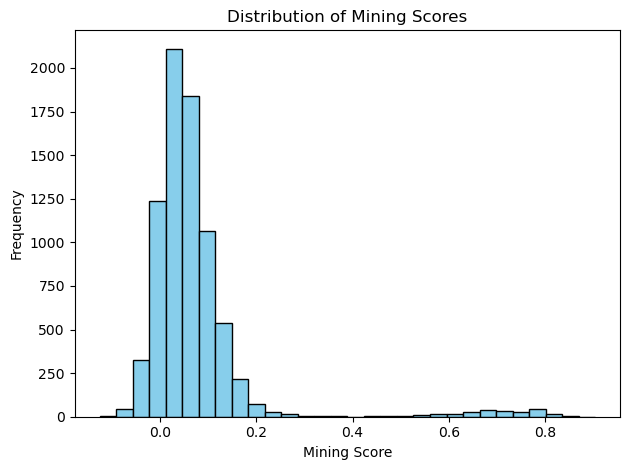

PRECISION,RECALL,F1
0.984,0.9879518072289156,0.9859719438877755


Batches:  23%|██▎       | 168/727 [04:58<13:52,  1.49s/it]

In [ ]:
run_experiment("labse")

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-06-13 16:02:46,843 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-06-13 16:02:47,241 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-06-13 16:02:47,248 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-06-13 16:02:47,249 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/train.english.laser.source.vec
2025-06-13 16:02:48,990 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/train.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-13T16:02:48.990484', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-13 16:02:48,991 | INFO

100%|██████████| 7749/7749 [00:00<00:00, 33695.28it/s]

2025-06-13 16:02:52,621 | WARNING | root | Saving results...


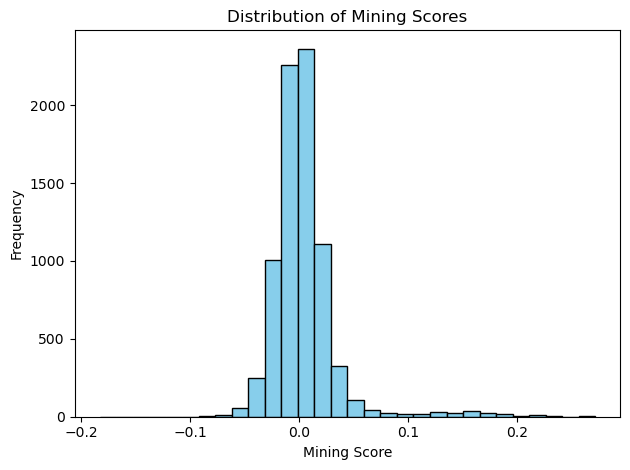

PRECISION,RECALL,F1
0.9372384937238494,0.8995983935742972,0.9180327868852459
2025-06-13 17:05:26,905 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.english.laser.source.vec
2025-06-13 17:05:32,713 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/test.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-13T17:05:32.713597', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-13 17:05:32,714 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.sinhala.laser.target.vec
2025-06-13 17:05:41,637 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/test.sinhala.laser.target.vec', 'binary': 0, 'encoding': '

100%|██████████| 23248/23248 [00:00<00:00, 41780.77it/s]

2025-06-13 17:05:57,256 | WARNING | root | Saving results...


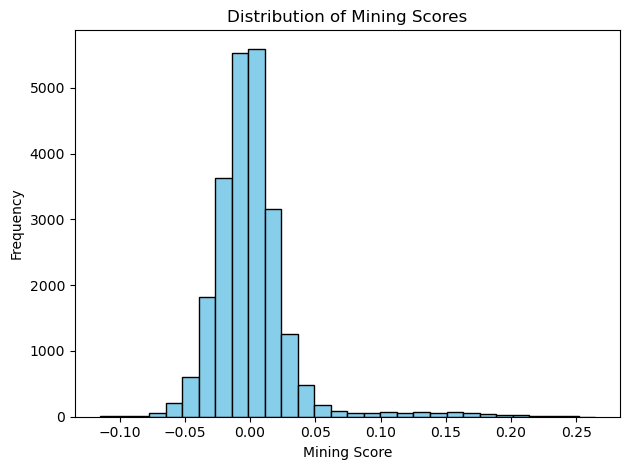

PRECISION,RECALL,F1
0.9213161659513591,0.8609625668449198,0.8901174844505875


In [6]:
run_experiment("laser")

2025-06-14 16:48:46,998 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-06-14 16:48:47,068 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-06-14 16:48:47,077 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-06-14 16:48:47,079 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/train.english.furina.source.vec
2025-06-14 16:48:51,851 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/train.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-14T16:48:51.851881', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-14 16:48:51,853 | INF

100%|██████████| 7749/7749 [00:00<00:00, 34717.02it/s]

2025-06-14 16:48:54,721 | WARNING | root | Saving results...


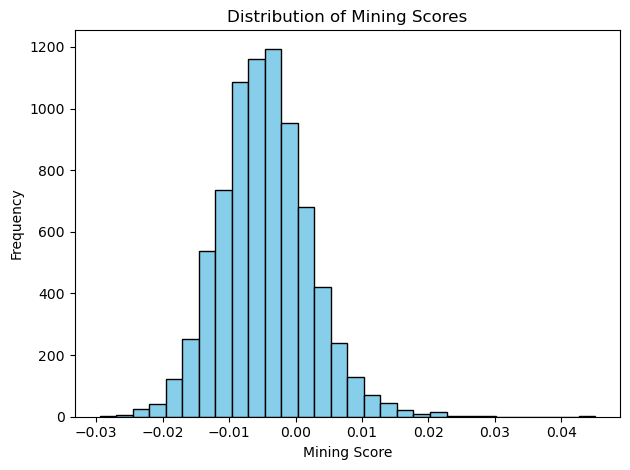

PRECISION,RECALL,F1
0.06329113924050633,0.060240963855421686,0.06172839506172839
2025-06-14 17:40:50,510 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.english.furina.source.vec
2025-06-14 17:40:54,430 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/test.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-14T17:40:54.430188', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-14 17:40:54,431 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.sinhala.furina.target.vec
2025-06-14 17:40:58,416 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/test.sinhala.furina.target.vec', 'binary': 0, 'encodi

100%|██████████| 23248/23248 [00:00<00:00, 48137.44it/s]

2025-06-14 17:41:08,160 | WARNING | root | Saving results...


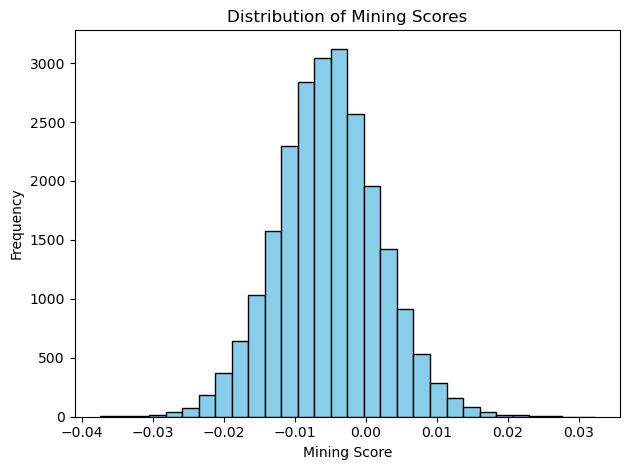

PRECISION,RECALL,F1
0.08739495798319327,0.06951871657754011,0.0774385703648548


In [6]:
run_experiment("furina")

2025-06-14 17:57:26,298 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/train.english.furina-indic.source.vec
2025-06-14 17:57:27,490 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/train.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-14T17:57:27.490085', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-14 17:57:27,490 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/train.sinhala.furina-indic.target.vec
2025-06-14 17:57:32,296 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/train.sinhala.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-14T17:57:32.296069',

100%|██████████| 7749/7749 [00:00<00:00, 36997.23it/s]

2025-06-14 17:57:33,540 | WARNING | root | Saving results...


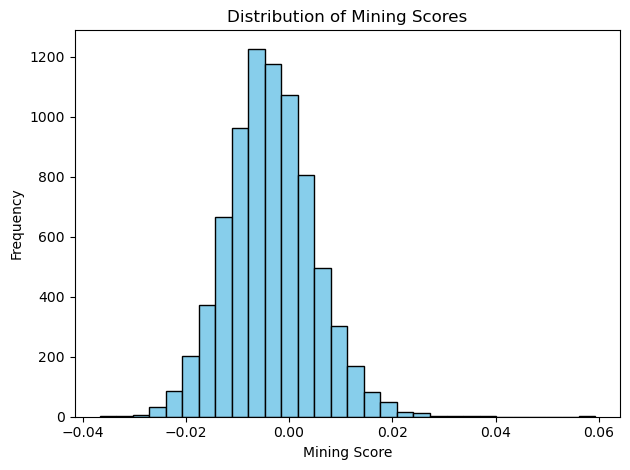

PRECISION,RECALL,F1
0.0892018779342723,0.07630522088353414,0.08225108225108224
2025-06-14 18:44:31,081 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.english.furina-indic.source.vec
2025-06-14 18:44:35,117 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/test.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-06-14T18:44:35.117324', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-06-14 18:44:35,118 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/test.sinhala.furina-indic.target.vec
2025-06-14 18:44:42,666 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/test.sinhala.furina-indic.target.vec'

100%|██████████| 23248/23248 [00:00<00:00, 56078.08it/s]

2025-06-14 18:44:52,579 | WARNING | root | Saving results...


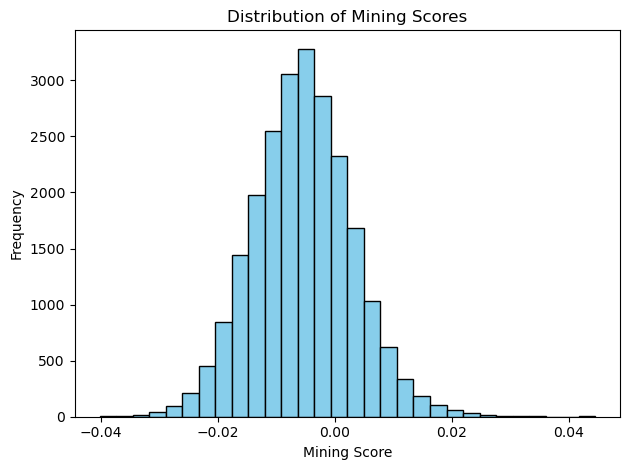

PRECISION,RECALL,F1
0.19,0.15240641711229946,0.16913946587537093


In [ ]:
run_experiment("furina-indic")
#dfdfdsfdf